# Student Loan Defaults and School Performance

## Overview 
---

This notebook will be a clean version of the code, but will have all the components necessary to run. Additional exporation and analysis will be done seperately, and is provided in the following notebook: SAVED
   [Some really messy data exporation and model building.](./Capstone.ipyn)  Much of the information is duplicated across notebooks.

   

This notebook will refer to the academic year by the early of the two dates. For example, the 2008-2009 academic year will be shortened to '2008'.

### Problem Statement

The student loan market in the U.S. is currently about 1.2 trillion dollars with roughly 90% coming from federal loan programs. It's not just large, it's growing rapidly as the cost of education continues to outpace the inflation. There is growing concern from both the public and policy makers about the burden that student loans are putting on the economy. 

But education has a lot of public benefits and student loans are not bad, per se. Graduating, $75k in debt might be ok if you're going to be surgeon, but could be troubling if your major was a soft science. And education fulfills a personal development goal as well, which has real value as well. The challenge for policy makers is recognizing when the loan amount becomes burdensome. Defaults are one good measure. Not only do they serve as a good marker for financial hardship but they bring about additional hardships as well.

There's also a challenge for loan originators when underwriting new debt. Nearly always, students don't have a credit history, and income during college is not a great predictor either. Many of the methods developed for determining defaults are legacy methods developed with pen and paper, when collecting and analyzing data was expensive and difficult.

> Is there a more efficient way to determine the probably of default on student loans?

This would mean, are there a lot of datapoints we can collect and analyze easily using some of the new tools available, or is there something inherit in the data we can look at to reconfigure the legacy system. 

## Data Overview
---
#### Source:

The U.S. Department of Education collects data on every postsecondary college and university for both 2-year and 4-year insitutions that are public, private, and for-profit. This project will leverage the back-end dataset from the 'College ScoreCard' complied for the Department of Education by a third-party consulting group, RTI (Research Triangle Institute) from the Departments own internal data and a number of other government datasets. The data is available for public consumption with two primarily goals; (i) to assist students in selecting a unversity and (ii) to assist policy makers with understanding institutional performance. 

Within the Department of Education the data in this set comes primarily from the IPEDS (Integrated Postsecondary Education Data System) data set described below and the NSLDS (National Student Loan Data System). The IPEDS dataset is collected through a survey of colleges conducted annually. The data is considered a primary source of information. Schools and University's recieve federal or state grant, financial aid, or other assistance are obligated to complete the survey in alignment with guidance provided by the Department. In addition to the survey information, the ScoreCard dataset also combines information from the U.S. Department of Treasury, and the Bureau of Labor Statistics (BLS).

The following policy directs the creation and scope of the dataset:
[https://collegescorecard.ed.gov/assets/BetterInformationForBetterCollegeChoiceAndInstitutionalPerformance.pdf]

The following technical paper analyizes the data and provides commentary on institutional performance. While much of the discussion is tangentially related to the problem statement, it does not directly address any of the issues discussed in this project.
[https://collegescorecard.ed.gov/assets/UsingFederalDataToMeasureAndImprovePerformance.pdf]


---

#### Data Overview:

The data set includes institutional level details for about 7,700 postsecondary schools that receives federal or state assistance. There is a file for every year dating back to 1996. Each file includes approx. 1700 unique features. Resulting in about (7,700 x 20 x 1,700) 262 million datapoints. 


The feature set can be broken into a few primary areas: 

**Root:** The root data is fundamental element, it includes the OPEID (Office of Postsecondary Education Identification) which uniquely identifies each institution and is standard across the Department of Education.

**School:** Descriptive information about each school. 

**Academics:** Metrics describing the type of education avialable.

**Admissions:** Admission statistics including acceptance rate and SAT scores.

**Student:** Demographic and descriptive elements about the student body.

**Cost:** Information about the cost of attendence. 

**Aid:** Statistics about financial aid and debt including the percentage of students recieving financial aid and the median debt at graduation.

**Repayment:** THE TARGET VARIABLES. This primarily includes  the cohort default rate and the repayment rate. (further discussion later)

**Completion:** Details of graduations rates. Can be based on 150% or 200% cap where additional scores are added if a student completes a program in the time longer than standard for that program.

**Earnings:** Information about post-graduation earnings. Earnings data are adjusted for inflation to 2014 using CPI-U from the BLS.





---
#### Data Dictionary:

A full data dictionary has been provided by the U.S. Department of Eduction and is available on their website. 


[https://collegescorecard.ed.gov/assets/FullDataDocumentation.pdf]                
and via excel here:                     
[https://collegescorecard.ed.gov/assets/CollegeScorecardDataDictionary-10-26-2016.xlsx]


---
#### Risks and Assumptions:

1. The target variable is the 7yr repayment rate for the FY2009 & FY2010 pooled cohorts. The circumstances of the economy during '08-'09 mean that default data for those years may not be reflective of other years.
2. The data provided is aggregated to the insitutional level. FERPA (Family Education Right to Privacy Act) laws prohibit distribution of personal education information. As a result, it not possible to validate results at the individual level. Any personally identifiable information in the data set as been replaced with "Privacy Supressed."
3. A lot of the data points provided are specific to first-time, full-time students and we extrapolate out to the rest of the student body even when this may not refect the composition. Further, much of the data, including earnings data is restricted to students who recieve Title IV benefits. At schools where this percentage is low, it may not reflect the overall student body, however, it is still useful as a comparison for default rates since these students are recieving aid.
4. As a method of simplifying the data analysis we ignore a lot of the transfer information.
5. The focus is on two-year and four year degree-granting programs only. Certificate programs and non-degree granting programs have been removed. 


## EDA
---

#### Data Cleaning

The first round of data cleaning was accomplished by writing a short program which takes the file name as an input from the user, goes through some data cleaning steps, and writes it as a csv to a seperate directory. The steps are detailed in the file and available here. ![](github

In [98]:
# Import every library. 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import plotly.plotly as py
import seaborn as sns
import datetime
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression, Lasso
from collections import Counter
import holoviews as hv
#from fancyimpute import KNN, SimpleFill

%matplotlib inline

###### Load the data into dataframes

In [2]:
data96 = pd.read_csv("/Users/timothyernst/GA-DSI/projects/projects-capstone/CollegeScorecard_Raw_Data/Cleaned_ScoreCard_Data/MERGED1996_97_PP_clean.csv")
data97 = pd.read_csv("/Users/timothyernst/GA-DSI/projects/projects-capstone/CollegeScorecard_Raw_Data/Cleaned_ScoreCard_Data/MERGED1997_98_PP_clean.csv")
data98 = pd.read_csv("/Users/timothyernst/GA-DSI/projects/projects-capstone/CollegeScorecard_Raw_Data/Cleaned_ScoreCard_Data/MERGED1998_99_PP_clean.csv")
data99 = pd.read_csv("/Users/timothyernst/GA-DSI/projects/projects-capstone/CollegeScorecard_Raw_Data/Cleaned_ScoreCard_Data/MERGED1999_00_PP_clean.csv")
data00 = pd.read_csv("/Users/timothyernst/GA-DSI/projects/projects-capstone/CollegeScorecard_Raw_Data/Cleaned_ScoreCard_Data/MERGED2000_01_PP_clean.csv")
data01 = pd.read_csv("/Users/timothyernst/GA-DSI/projects/projects-capstone/CollegeScorecard_Raw_Data/Cleaned_ScoreCard_Data/MERGED2001_02_PP_clean.csv")
data02 = pd.read_csv("/Users/timothyernst/GA-DSI/projects/projects-capstone/CollegeScorecard_Raw_Data/Cleaned_ScoreCard_Data/MERGED2002_03_PP_clean.csv")
data03 = pd.read_csv("/Users/timothyernst/GA-DSI/projects/projects-capstone/CollegeScorecard_Raw_Data/Cleaned_ScoreCard_Data/MERGED2003_04_PP_clean.csv")
data04 = pd.read_csv("/Users/timothyernst/GA-DSI/projects/projects-capstone/CollegeScorecard_Raw_Data/Cleaned_ScoreCard_Data/MERGED2004_05_PP_clean.csv")
data05 = pd.read_csv("/Users/timothyernst/GA-DSI/projects/projects-capstone/CollegeScorecard_Raw_Data/Cleaned_ScoreCard_Data/MERGED2005_06_PP_clean.csv")
data06 = pd.read_csv("/Users/timothyernst/GA-DSI/projects/projects-capstone/CollegeScorecard_Raw_Data/Cleaned_ScoreCard_Data/MERGED2006_07_PP_clean.csv")
data07 = pd.read_csv("/Users/timothyernst/GA-DSI/projects/projects-capstone/CollegeScorecard_Raw_Data/Cleaned_ScoreCard_Data/MERGED2007_08_PP_clean.csv")
data08 = pd.read_csv("/Users/timothyernst/GA-DSI/projects/projects-capstone/CollegeScorecard_Raw_Data/Cleaned_ScoreCard_Data/MERGED2008_09_PP_clean.csv")
data09 = pd.read_csv("/Users/timothyernst/GA-DSI/projects/projects-capstone/CollegeScorecard_Raw_Data/Cleaned_ScoreCard_Data/MERGED2009_10_PP_clean.csv")
data10 = pd.read_csv("/Users/timothyernst/GA-DSI/projects/projects-capstone/CollegeScorecard_Raw_Data/Cleaned_ScoreCard_Data/MERGED2010_11_PP_clean.csv")
data11 = pd.read_csv("/Users/timothyernst/GA-DSI/projects/projects-capstone/CollegeScorecard_Raw_Data/Cleaned_ScoreCard_Data/MERGED2011_12_PP_clean.csv")
data12 = pd.read_csv("/Users/timothyernst/GA-DSI/projects/projects-capstone/CollegeScorecard_Raw_Data/Cleaned_ScoreCard_Data/MERGED2012_13_PP_clean.csv")
data13 = pd.read_csv("/Users/timothyernst/GA-DSI/projects/projects-capstone/CollegeScorecard_Raw_Data/Cleaned_ScoreCard_Data/MERGED2013_14_PP_clean.csv")
data14 = pd.read_csv("/Users/timothyernst/GA-DSI/projects/projects-capstone/CollegeScorecard_Raw_Data/Cleaned_ScoreCard_Data/MERGED2014_15_PP_clean.csv")

/Users/timothyernst/anaconda/envs/Python2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.

/Users/timothyernst/anaconda/envs/Python2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning:

Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.



In [3]:
# Generate new dataframes for the two primary, that can be refered back to without having to read in the csv agian.
df08 = data08
df14 = data14

In [423]:
# Generate data from for the remaining years as well.
df96 = data96
df97 = data97
df98 = data98
df99 = data99
df00 = data00
df01 = data01
df02 = data02
df03 = data03
df04 = data04
df05 = data05
df06 = data06
df07 = data07
df09 = data09
df10 = data10
df11 = data11
df12 = data12
df13 = data13

In [4]:
df08.head()

,Unnamed: 0,UNITID,OPEID,INSTNM,CITY,ZIP,ACCREDAGENCY,SCH_DEG,PREDDEG,HIGHDEG,...,FEMALE_RPY_3YR_RT_SUPP,MALE_RPY_3YR_RT_SUPP,FIRSTGEN_RPY_3YR_RT_SUPP,NOTFIRSTGEN_RPY_3YR_RT_SUPP,C150_L4_POOLED_SUPP,C150_4_POOLED_SUPP,UGDS_MEN,UGDS_WOMEN,CDR2_DENOM,CDR3_DENOM
0,0,100654,100200,Alabama A & M University,Normal,35762,NaN,3.0,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,0.4601,0.5399,1781.0,NaN
1,1,100663,105200,University of Alabama at Birmingham,Birmingham,35294-0110,NaN,3.0,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,0.4025,0.5975,3271.0,NaN
2,2,100690,2503400,Amridge University,Montgomery,36117-3553,NaN,3.0,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,0.5028,0.4972,291.0,NaN
3,3,100706,105500,University of Alabama in Huntsville,Huntsville,35899,NaN,3.0,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,0.5273,0.4727,1077.0,NaN
4,4,100724,100500,Alabama State University,Montgomery,36104-0271,NaN,3.0,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,0.4203,0.5797,2088.0,NaN


In [35]:
# Remove the index that remained after the data cleaning program.
del df08["Unnamed: 0"]
del df14["Unnamed: 0"]

KeyError: 'Unnamed: 0'

###### Target Variable Investigation

Basic EDA on the target variable. Our data also comes with breakdowns of the target based on other values. We can plot those and see if there are insights in the breakdown provided.

For our investigation the target variable is **RPY_7YR_RT** which represents, "Fraction of repayment cohort who are not in default, and with loan balances that have declined seven years since entering repayment, excluding enrolled and military deferment from calculation. (rolling averages)". Unfortunately, this variable is only avialable in the 2013 and 2014 files. The figures in those two files represent the default rate of the cohort 7 years previous.

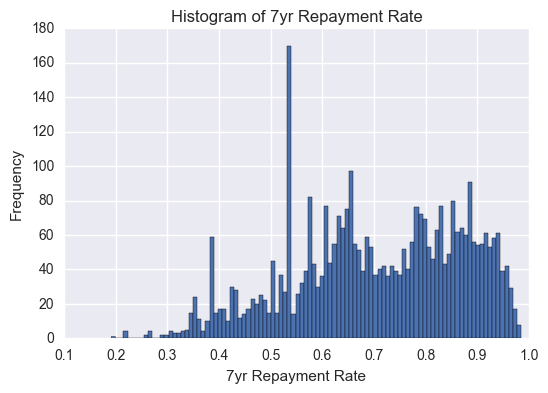

In [6]:
#Display a histogram of the target variable.
df14["RPY_7YR_RT"].hist(bins=100)
plt.xlabel('7yr Repayment Rate')
plt.ylabel('Frequency')
plt.title(r'Histogram of 7yr Repayment Rate')
plt.show()

In [7]:
# Investigate the spike in the data.
df14x = df14[(df14["RPY_7YR_RT"] > 0.5) & (df14["RPY_7YR_RT"] < 0.55)]
df14x = df14x[["INSTNM", "RPY_7YR_RT"]]
df14x

,INSTNM,RPY_7YR_RT
5,Central Alabama Community College,0.510127
49,Stillman College,0.508562
63,Carrington College-Phoenix,0.520510
64,Carrington College-Mesa,0.520510
65,Carrington College-Tucson,0.520510
72,Central Arizona College,0.527778
81,ITT Technical Institute-Tucson,0.534647
82,ITT Technical Institute-Tempe,0.534647
93,Refrigeration School Inc,0.548263
116,East Arkansas Community College,0.505319


The spike is the result of ITT institutes each reporting the same default rate for all of thier campuses. They don't appear to hold enough valueable information and can be removed. 

In [8]:
# Remove row's with the same Repayment rate as the ITT campuses.
df14 = df14.loc[(df14["RPY_7YR_RT"] < 0.5346) | (df14["RPY_7YR_RT"] > 0.5347)]

In [23]:
# Remove any columns with completely null values
df14.dropna(how='all', axis=1, inplace=True)

# Remove any columns with more than 1000 null fields.
df14.dropna(thresh=len(df14) - 1000, axis=1, inplace=True)

# Drop any of the rows where our target is null.
df14["RPY_7YR_RT"].dropna(how='any', axis=0, inplace=True)

/Users/timothyernst/anaconda/envs/Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/timothyernst/anaconda/envs/Python2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/timothyernst/anaconda/envs/Python2/lib/python2.7/site-packages/pandas/core/series.py:2571: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [39]:
df14.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3483 entries, 0 to 4054
Data columns (total 199 columns):
UNITID                         int64
OPEID                          int64
INSTNM                         object
CITY                           object
ZIP                            object
ACCREDAGENCY                   object
PREDDEG                        int64
HIGHDEG                        int64
CONTROL                        int64
REGION                         int64
LOCALE                         float64
HBCU                           float64
PBI                            float64
ANNHI                          float64
TRIBAL                         float64
AANAPII                        float64
HSI                            float64
NANTI                          float64
MENONLY                        float64
WOMENONLY                      float64
DISTANCEONLY                   float64
UGDS                           float64
COSTT4_A                       float64
TUITIONFEE_

In [487]:
from datetime import timedelta

df082 = data08
dfs = {"years" : [df96, df97, df98, df99, df00, df01, df02, df03, df04, df05, df06, df07, df082, df09, df10, df11, df12]}

#Initialize the starting year.
rates = []
yrs = []
y = datetime.date(1995, 1,1)
yr = y.year

# Loop throug the dataframes in the dictionary.
for i in dfs["years"]:
     j = i["CDR2"].mean()
     rates.append(j)
     yrs.append(yr)
     yr += 1

# The last two years move to a 3yr default rate. We need to append those individually. 
y2 = datetime.date(2012, 1,1)
yr2 = y2.year #initialize years for 3yr default.

y3 = datetime.date(2013, 1,1)
yr3 = y3.year #initialize years for 3yr default.

df1 = pd.DataFrame()
df1['CDR'] = rates
df1['Years'] = yrs
df12rt = pd.DataFrame([[df13["CDR3"].mean(), yr2],[df14["CDR3"].mean(), yr3]] , columns=df1.columns)
df1 = df1.append(df12rt)
df1

,CDR,Years
0,0.105885,1995
1,0.099998,1996
2,0.091160,1997
3,0.073641,1998
4,NaN,1999
5,0.063936,2000
6,0.058706,2001
7,0.055564,2002
8,0.048562,2003
9,0.053852,2004


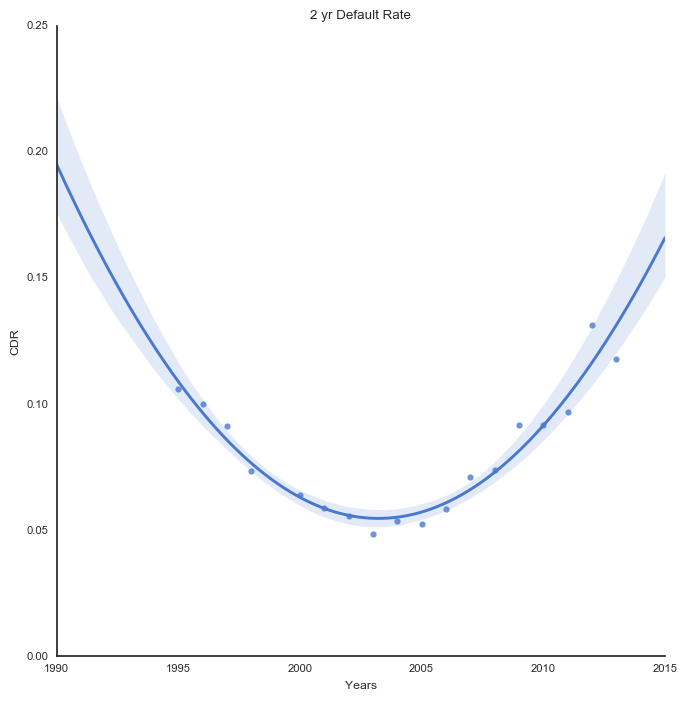

In [493]:
# Graph 2 yr (& 3 yr) default rates over time. 
sns.lmplot("Years","CDR",data=df1, size=7, order=2)
plt.title(r'2 yr Default Rate')

In [40]:
df14.describe()

/Users/timothyernst/anaconda/envs/Python2/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning:

Invalid value encountered in percentile



,UNITID,OPEID,PREDDEG,HIGHDEG,CONTROL,REGION,LOCALE,HBCU,PBI,ANNHI,...,IND_RPY_3YR_RT_SUPP,PELL_RPY_3YR_RT_SUPP,NOPELL_RPY_3YR_RT_SUPP,FEMALE_RPY_3YR_RT_SUPP,MALE_RPY_3YR_RT_SUPP,FIRSTGEN_RPY_3YR_RT_SUPP,NOTFIRSTGEN_RPY_3YR_RT_SUPP,UGDS_MEN,UGDS_WOMEN,CDR3_DENOM
count,3483.000000,3.483000e+03,3483.000000,3483.000000,3483.000000,3483.000000,3483.000000,3483.000000,3483.000000,3483.000000,...,3120.000000,3239.000000,3234.000000,3263.000000,3260.000000,3296.000000,3296.000000,3483.000000,3483.000000,3441.000000
mean,230062.987654,1.234330e+06,2.349699,3.065461,1.867069,4.544358,20.129773,0.024978,0.019811,0.006604,...,0.597295,0.611983,0.762821,0.659775,0.628892,0.630128,0.659939,0.397109,0.602891,5304.568149
std,109521.360469,4.255291e+06,0.745669,0.900423,0.806253,2.121516,9.846807,0.156082,0.139369,0.081005,...,0.180605,0.196994,0.149439,0.197663,0.206858,0.193227,0.196734,0.157784,0.157784,20970.327945
min,100654.000000,1.002000e+05,1.000000,2.000000,1.000000,1.000000,11.000000,0.000000,0.000000,0.000000,...,0.131765,0.127660,0.226190,0.148041,0.110448,0.121464,0.156028,0.000000,0.000000,30.000000
25%,155491.500000,2.361500e+05,2.000000,2.000000,1.000000,3.000000,12.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.316400,0.527850,NaN
50%,198835.000000,3.669000e+05,3.000000,3.000000,2.000000,5.000000,21.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.411000,0.589000,NaN
75%,236730.500000,1.044350e+06,3.000000,4.000000,3.000000,6.000000,23.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.472150,0.683600,NaN
max,485263.000000,8.209882e+07,4.000000,4.000000,3.000000,9.000000,43.000000,1.000000,1.000000,1.000000,...,0.961207,0.965608,0.991498,0.988730,0.980716,0.965839,0.989183,1.000000,1.000000,201163.000000


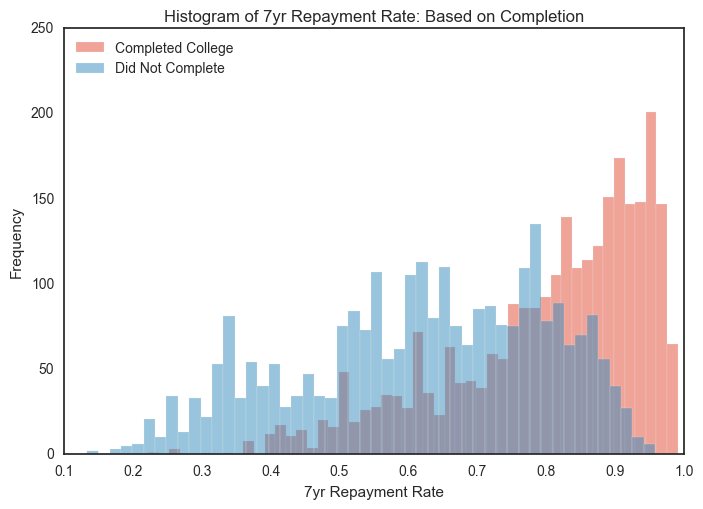

In [340]:
# Configure the data
completed = pd.Series(df14["COMPL_RPY_7YR_RT"].dropna())
not_completed = pd.Series(df14["NONCOM_RPY_7YR_RT"].dropna())

# Plot the histogram
fig, ax = plt.subplots()
plt.style.use('seaborn-white')
ax.hist(completed, bins=50, alpha=.5, label='Completed College')
ax.hist(not_completed, bins=50, alpha=.5, label='Did Not Complete')
plt.xlabel('7yr Repayment Rate')
plt.ylabel('Frequency')
plt.title(r'Histogram of 7yr Repayment Rate: Based on Completion')
ax.legend(loc='upper left')
#ax.show()

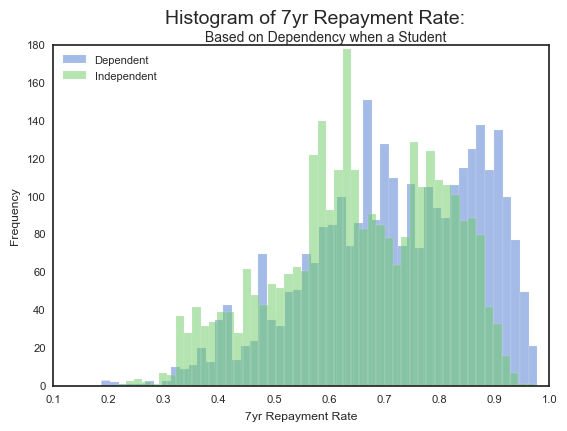

In [407]:
# Configure the data
dependent = pd.Series(df14["DEP_RPY_7YR_RT"].dropna())
independent = pd.Series(df14["IND_RPY_7YR_RT"].dropna())

# Plot the histogram
fig, ax = plt.subplots()
plt.style.use('seaborn-white')
ax.hist(dependent, bins=50, alpha=.5, label='Dependent')
ax.hist(independent, bins=50, alpha=.5, label='Independent')
plt.xlabel('7yr Repayment Rate')
plt.ylabel('Frequency')
plt.figtext(.3,.95, "Histogram of 7yr Repayment Rate:", fontsize=14)
plt.figtext(.55,.91,'Based on Dependency when a Student',fontsize=10,ha='center')
ax.legend(loc='upper left')
#ax.show()

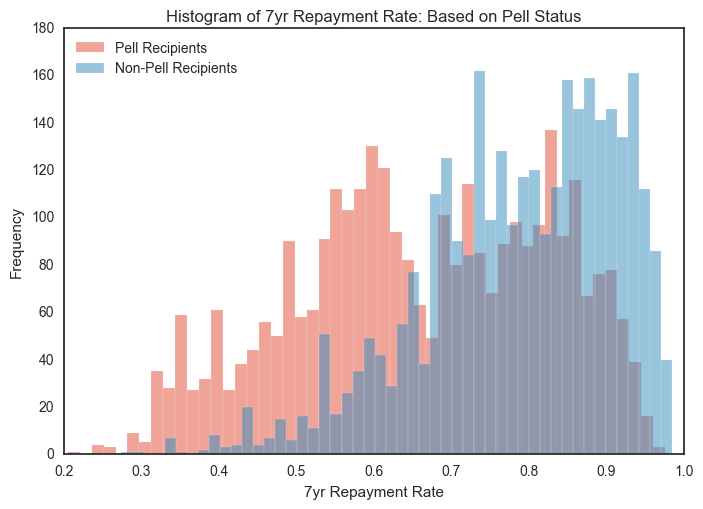

In [342]:
# Configure the data
pell = pd.Series(df14["PELL_RPY_7YR_RT"].dropna())
nopell = pd.Series(df14["NOPELL_RPY_7YR_RT"].dropna())

# Plot the histogram
fig, ax = plt.subplots()
plt.style.use('seaborn-white')
ax.hist(pell, bins=50, alpha=.5, label='Pell Recipients')
ax.hist(nopell, bins=50, alpha=.5, label='Non-Pell Recipients')
plt.xlabel('7yr Repayment Rate')
plt.ylabel('Frequency')
plt.title(r'Histogram of 7yr Repayment Rate: Based on Pell Status')
ax.legend(loc='upper left')
#ax.show()

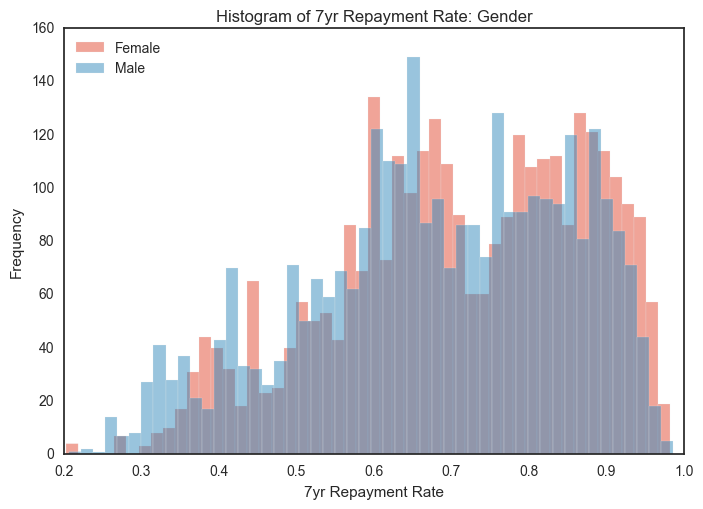

In [343]:
# Configure the data
female = pd.Series(df14["FEMALE_RPY_7YR_RT"].dropna())
male = pd.Series(df14["MALE_RPY_7YR_RT"].dropna())

# Plot the histogram
fig, ax = plt.subplots()
plt.style.use('seaborn-white')
ax.hist(female, bins=50, alpha=.5, label='Female')
ax.hist(male, bins=50, alpha=.5, label='Male')
plt.xlabel('7yr Repayment Rate')
plt.ylabel('Frequency')
plt.title(r'Histogram of 7yr Repayment Rate: Gender')
ax.legend(loc='upper left')
#ax.show()

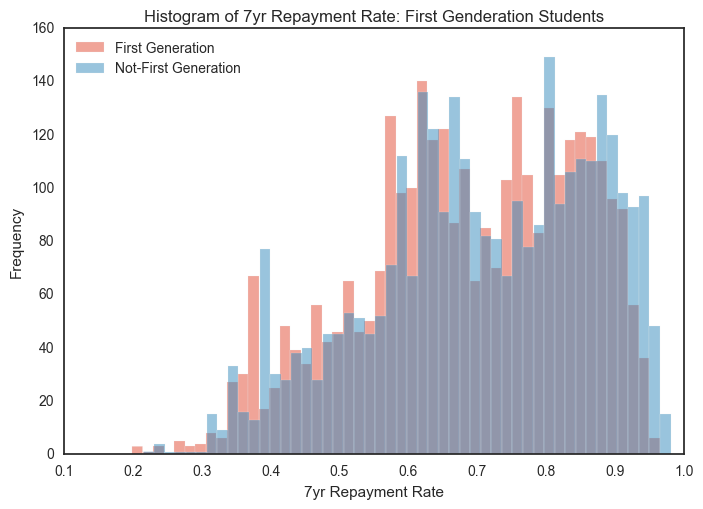

In [344]:
# Configure the data
firstgen = pd.Series(df14["FIRSTGEN_RPY_7YR_RT"].dropna())
notfirstgen = pd.Series(df14["NOTFIRSTGEN_RPY_7YR_RT"].dropna())

# Plot the histogram
fig, ax = plt.subplots()
plt.style.use('seaborn-white')
ax.hist(firstgen, bins=50, alpha=.5, label='First Generation')
ax.hist(notfirstgen, bins=50, alpha=.5, label='Not-First Generation')
plt.xlabel('7yr Repayment Rate')
plt.ylabel('Frequency')
plt.title(r'Histogram of 7yr Repayment Rate: First Genderation Students')
ax.legend(loc='upper left')
#ax.show()

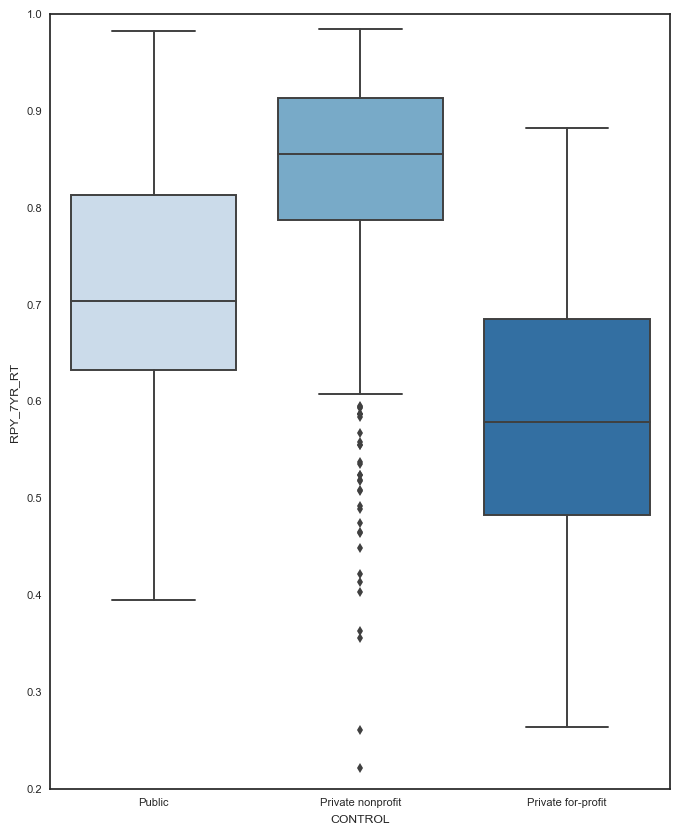

In [405]:
fig, ax = plt.subplots(figsize=(8,10))
ax = sns.boxplot(x="CONTROL", y="RPY_7YR_RT", data=df08, palette="Blues")
ax.set_xticklabels(["Public","Private nonprofit", "Private for-profit"], rotation=0)

**Analysis**

---
The graphs above mostly come from data that was aggregated at the student level and provided in our dataset. We've stripped it out of future analysis because of the obvious abaility to distrupt the model. 

Clearly, Pell eligibility status and college completion have strong impacts on repayment rate, but somewhat surprisingly, geneder and whether a first generation student have very little impact on repayment rates. 


###### Feature Importance

The section below takes a look at what features are important for our model. This can be examined by calling 'feature importances' on the random forest model. We've selected random forests for a couple of reasons; (1) limited preprosessing steps, (2) the method of splitting based on the features ability to divide the data provides a good indication of the importance of that feature, and (3) it looks as though our data could have multicollinearity and random forests is best suited to not overfit based on this. Before the model can be built the 2008 data needs to be cleaned and the 7yr default rate has to be moved from the 2014 data into the 2008 cohort data it relates to.

In [82]:
# Select on the columns we want. This excludes a lot of the data that's correlated with the target. e.g. 7yr default rate for Pell students.
df08 = df08[[ 
"OPEID",
"INSTNM",
"CITY",
"ACCREDAGENCY",
"SCH_DEG",
"PREDDEG",
"HIGHDEG",
"CONTROL",
"REGION",
"LOCALE",
"HBCU",
"PBI",
"ANNHI",
"TRIBAL",
"AANAPII",
"HSI",
"NANTI",
"MENONLY",
"WOMENONLY",
"ADM_RATE_ALL",
"SATVR25",
"SATVR75",
"SATMT25",
"SATMT75",
"SATWR25",
"SATWR75",
"SATVRMID",
"SATMTMID",
"SATWRMID",
"DISTANCEONLY",
"UGDS",
"NPT4_PUB",
"NPT4_PRIV",
"NPT41_PUB",
"NPT42_PUB",
"NPT43_PUB",
"NPT44_PUB",
"NPT45_PUB",
"NPT41_PRIV",
"NPT42_PRIV",
"NPT43_PRIV",
"NPT44_PRIV",
"NPT45_PRIV",
"NUM4_PUB",
"NUM4_PRIV",
"NUM41_PUB",
"NUM42_PUB",
"NUM43_PUB",
"NUM44_PUB",
"NUM45_PUB",
"NUM41_PRIV",
"NUM42_PRIV",
"NUM43_PRIV",
"NUM44_PRIV",
"NUM45_PRIV",
"COSTT4_A",
"TUITIONFEE_IN",
"TUITIONFEE_OUT",
"TUITIONFEE_PROG",
"TUITFTE",
"INEXPFTE",
"AVGFACSAL",
"PFTFAC",
"PCTPELL",
"C150_4",
"PFTFTUG1_EF",
"D150_4",
"RET_FT4",
"RET_FTL4",
"RET_PT4",
"RET_PTL4",
"PCTFLOAN",
"UG25ABV",
"COMP_4YR_TRANS_YR2_RT",
"COMP_2YR_TRANS_YR2_RT",
"WDRAW_ORIG_YR2_RT",
"WDRAW_4YR_TRANS_YR2_RT",
"WDRAW_2YR_TRANS_YR2_RT",
"ENRL_ORIG_YR2_RT",
"ENRL_4YR_TRANS_YR2_RT",
"ENRL_2YR_TRANS_YR2_RT",
"UNKN_ORIG_YR2_RT",
"UNKN_4YR_TRANS_YR2_RT",
"UNKN_2YR_TRANS_YR2_RT",
"RPY_7YR_RT",
"INC_PCT_LO",
"DEP_STAT_PCT_IND",
"DEP_INC_PCT_LO",
"IND_INC_PCT_LO",
"PAR_ED_PCT_1STGEN",
"INC_PCT_M1",
"INC_PCT_M2",
"INC_PCT_H1",
"INC_PCT_H2",
"DEP_INC_PCT_M1",
"DEP_INC_PCT_M2",
"DEP_INC_PCT_H1",
"DEP_INC_PCT_H2",
"IND_INC_PCT_M1",
"IND_INC_PCT_M2",
"IND_INC_PCT_H1",
"IND_INC_PCT_H2",
"PAR_ED_PCT_MS",
"PAR_ED_PCT_HS",
"PAR_ED_PCT_PS",
"DEP_INC_AVG",
"IND_INC_AVG",
"OVERALL_YR2_N",
"LO_INC_YR2_N",
"MD_INC_YR2_N",
"HI_INC_YR2_N",
"DEP_YR2_N",
"IND_YR2_N",
"FEMALE_YR2_N",
"MALE_YR2_N",
"PELL_YR2_N",
"NOPELL_YR2_N",
"LOAN_YR2_N",
"NOLOAN_YR2_N",
"FIRSTGEN_YR2_N",
"NOT1STGEN_YR2_N",
"DEBT_MDN",
"GRAD_DEBT_MDN",
"WDRAW_DEBT_MDN",
"LO_INC_DEBT_MDN",
"MD_INC_DEBT_MDN",
"HI_INC_DEBT_MDN",
"DEP_DEBT_MDN",
"IND_DEBT_MDN",
"PELL_DEBT_MDN",
"NOPELL_DEBT_MDN",
"FEMALE_DEBT_MDN",
"MALE_DEBT_MDN",
"FIRSTGEN_DEBT_MDN",
"NOTFIRSTGEN_DEBT_MDN",
"DEBT_N",
"GRAD_DEBT_N",
"WDRAW_DEBT_N",
"LO_INC_DEBT_N",
"MD_INC_DEBT_N",
"HI_INC_DEBT_N",
"DEP_DEBT_N",
"IND_DEBT_N",
"PELL_DEBT_N",
"NOPELL_DEBT_N",
"FEMALE_DEBT_N",
"MALE_DEBT_N",
"FIRSTGEN_DEBT_N",
"NOTFIRSTGEN_DEBT_N",
"GRAD_DEBT_MDN10YR",
"CUML_DEBT_N",
"CUML_DEBT_P90",
"CUML_DEBT_P75",
"CUML_DEBT_P25",
"CUML_DEBT_P10",
"INC_N",
"DEP_INC_N",
"IND_INC_N",
"DEP_STAT_N",
"PAR_ED_N",
"APPL_SCH_N",
"REPAY_DT_N",
"SEPAR_DT_N",
"COUNT_ED",
"LOAN_EVER",
"PELL_EVER",
"MARRIED",
"DEPENDENT",
"VETERAN",
"FIRST_GEN",
"FAMINC",
"MD_FAMINC",
"FAMINC_IND",
"PCT_BA",
"PCT_GRAD_PROF",
"MEDIAN_HH_INC",
"POVERTY_RATE",
"UNEMP_RATE",
"LN_MEDIAN_HH_INC",
"COUNT_NWNE_P10",
"COUNT_WNE_P10",
"DEBT_MDN_SUPP",
"GRAD_DEBT_MDN_SUPP",
"GRAD_DEBT_MDN10YR_SUPP",
"C150_L4_POOLED_SUPP",
"C150_4_POOLED_SUPP",
"UGDS_MEN",
"UGDS_WOMEN",
"CDR2_DENOM",
"CDR3_DENOM"]]

In [83]:
# Drop any columns with more than 1000 nulls.
df08.dropna(thresh=len(df08) - 1000, axis=1, inplace=True)

# Define two dataframes to be imputed or not imputed.
df08_toimp = df08.iloc[:,4:]
df08_noimp = df08.iloc[:,:3]

# Impute remaining null values and bring the dataframes back together.
imp = Imputer(missing_values='NaN', strategy='median', axis=0)                
imputed_df = imp.fit_transform(df08_toimp)   
df08_toimp = pd.DataFrame(imputed_df, index=df08_toimp.index, columns = df08_toimp.columns)
df08 = pd.concat([df08_noimp, df08_toimp], axis=1)
df08.head(10)

/Users/timothyernst/anaconda/envs/Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,OPEID,INSTNM,CITY,PREDDEG,HIGHDEG,CONTROL,REGION,UGDS,TUITIONFEE_IN,TUITIONFEE_OUT,...,FIRST_GEN,FAMINC,MD_FAMINC,FAMINC_IND,DEBT_MDN_SUPP,GRAD_DEBT_MDN_SUPP,GRAD_DEBT_MDN10YR_SUPP,UGDS_MEN,UGDS_WOMEN,CDR2_DENOM
0,100200,Alabama A & M University,Normal,3.0,4.0,1.0,5.0,4290.0,4072.0,7304.0,...,0.404070,40257.95204,28917.53262,17173.576289,8375.0,19750.0,202.692481,0.4601,0.5399,1781.0
1,105200,University of Alabama at Birmingham,Birmingham,3.0,4.0,1.0,5.0,9989.0,4664.0,10352.0,...,0.367703,55196.00660,40177.83983,30505.196289,7940.0,13362.5,137.138140,0.4025,0.5975,3271.0
2,2503400,Amridge University,Montgomery,3.0,4.0,2.0,5.0,356.0,6600.0,6600.0,...,0.522222,36272.92642,28479.07391,35730.857989,8001.0,13795.0,141.576849,0.5028,0.4972,291.0
3,105500,University of Alabama in Huntsville,Huntsville,3.0,4.0,1.0,5.0,5689.0,5952.0,13092.0,...,0.338022,56975.08301,41584.96184,28523.716951,7731.0,15450.0,158.561966,0.5273,0.4727,1077.0
4,100500,Alabama State University,Montgomery,3.0,4.0,1.0,5.0,4730.0,5460.0,10068.0,...,0.434021,31955.59480,23895.68713,14536.847331,7036.0,21500.0,220.652574,0.4203,0.5797,2088.0
5,105100,The University of Alabama,Tuscaloosa,3.0,4.0,1.0,5.0,22046.0,6400.0,18000.0,...,0.280833,86225.87275,67754.21290,27079.296233,9875.0,15750.0,161.640839,0.4722,0.5278,3120.0
6,100700,Central Alabama Community College,Alexander City,2.0,2.0,1.0,5.0,2101.0,2700.0,4830.0,...,0.621579,26749.35930,19783.16002,18694.630879,4243.0,7523.5,77.213006,0.3256,0.6744,427.0
7,100800,Athens State University,Athens,3.0,3.0,1.0,5.0,3114.0,9115.5,12742.0,...,0.525061,43979.98322,33417.33296,37401.586099,8878.0,14666.0,150.515844,0.3243,0.6757,664.0
8,831000,Auburn University at Montgomery,Montgomery,3.0,4.0,1.0,5.0,4457.0,5580.0,16200.0,...,0.405123,45727.56587,31077.91358,27196.424445,6156.5,13201.5,135.485812,0.3731,0.6269,1364.0
9,100900,Auburn University,Auburn,3.0,4.0,1.0,5.0,20032.0,6500.0,18260.0,...,0.235996,94032.48591,74602.73500,19181.300271,10500.0,14583.0,149.664022,0.5134,0.4866,3148.0


In [84]:
# Append the default rate from our other column to this one.
df08 = pd.merge(df08, df14[["OPEID","RPY_7YR_RT"]], on="OPEID", how='left')

In [87]:
# Determine how many of our target variables are null.
print df08["RPY_7YR_RT"].isnull().sum()

# Remove any columns with a null target.
df08.dropna(axis=0, inplace=True)

2157


In [89]:
# Define a new dataframe to use for the model.
df08rf = df08.iloc[:, 3:]
df08rf.head()

,PREDDEG,HIGHDEG,CONTROL,REGION,UGDS,TUITIONFEE_IN,TUITIONFEE_OUT,TUITFTE,INEXPFTE,AVGFACSAL,...,FAMINC,MD_FAMINC,FAMINC_IND,DEBT_MDN_SUPP,GRAD_DEBT_MDN_SUPP,GRAD_DEBT_MDN10YR_SUPP,UGDS_MEN,UGDS_WOMEN,CDR2_DENOM,RPY_7YR_RT
0,3.0,4.0,1.0,5.0,4290.0,4072.0,7304.0,5447.0,5544.0,6421.0,...,40257.95204,28917.53262,17173.576289,8375.0,19750.0,202.692481,0.4601,0.5399,1781.0,0.569782
1,3.0,4.0,1.0,5.0,9989.0,4664.0,10352.0,5229.0,16379.0,8666.0,...,55196.00660,40177.83983,30505.196289,7940.0,13362.5,137.138140,0.4025,0.5975,3271.0,0.809797
3,3.0,4.0,1.0,5.0,5689.0,5952.0,13092.0,5494.0,7500.0,7812.0,...,56975.08301,41584.96184,28523.716951,7731.0,15450.0,158.561966,0.5273,0.4727,1077.0,0.798599
4,3.0,4.0,1.0,5.0,4730.0,5460.0,10068.0,5461.0,5899.0,6367.0,...,31955.59480,23895.68713,14536.847331,7036.0,21500.0,220.652574,0.4203,0.5797,2088.0,0.487878
5,3.0,4.0,1.0,5.0,22046.0,6400.0,18000.0,8010.0,7932.0,8230.0,...,86225.87275,67754.21290,27079.296233,9875.0,15750.0,161.640839,0.4722,0.5278,3120.0,0.832807


In [91]:
#Define the X and y.
features = [c for c in df08rf.columns if c != 'RPY_7YR_RT']

X = df08rf[features]
y = df08rf['RPY_7YR_RT']

In [92]:
# Generate a train, test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

###### Feature Importance Using Random Forest

In [93]:
# Fit a Random Forest Regressor. No tuning of hyper-parameters just yet.
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [94]:
# Examine the model error to ensure our model has value.
mse = mean_squared_error(y_test, rfr.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 0.0038


In [95]:
# Review the R2 value to see if the model has predictive power.
y_true = y_test
y_pred = rfr.predict(X_test)

rfr_r2 = r2_score(y_true, y_pred)
rfr_r2

0.79421725148596956

Our MSE of 0.0038 and r2 of 0.8 are fairly strong results. Certainly strong enough for the purpose of determining which features our final model should use.

In [96]:
# Generate the feature importance off the initial random forest model.
feature_importances = pd.DataFrame(rfr.feature_importances_,
                                   index = features,
                                    columns=['importance'])
feature_importances.sort_values(by='importance', ascending=False)

,importance
FAMINC,0.508795
INC_PCT_M1,0.066574
PELL_EVER,0.058634
PCTPELL,0.047115
INC_PCT_LO,0.031309
ENRL_ORIG_YR2_RT,0.024091
MD_FAMINC,0.023885
DEP_INC_AVG,0.017953
PAR_ED_PCT_PS,0.016900
WDRAW_ORIG_YR2_RT,0.016264


In [139]:
df08hm = df08[[
"FAMINC",
"INC_PCT_M1",
"PELL_EVER",
"PCTPELL",
"INC_PCT_LO",
"ENRL_ORIG_YR2_RT",
"MD_FAMINC",
"DEP_INC_AVG",
"PAR_ED_PCT_PS",
"WDRAW_ORIG_YR2_RT",
"AVGFACSAL",
"PAR_ED_PCT_HS",
"INEXPFTE",
"DEP_INC_PCT_LO",
"LO_INC_DEBT_N",
"CUML_DEBT_P90",
"PAR_ED_PCT_1STGEN",
"LOAN_EVER",
"PFTFTUG1_EF",
"RPY_7YR_RT",
"ENRL_4YR_TRANS_YR2_RT",
"INC_PCT_H2",
"UNKN_ORIG_YR2_RT",
"REGION",
"FIRST_GEN",
"CUML_DEBT_P25",
"FAMINC_IND",
"IND_INC_AVG",]]

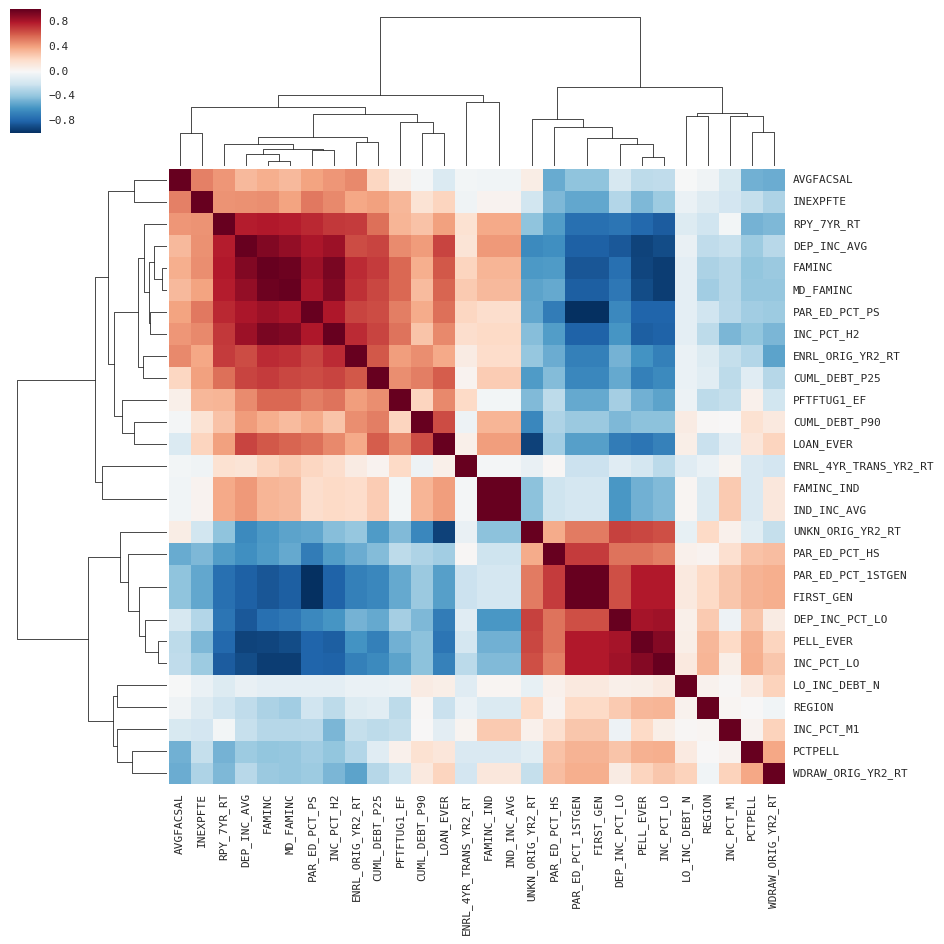

In [158]:
corrmat = df08hm.corr()
g = sns.clustermap(corrmat)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0) # Rotated the y label ticks. 
plt.show()

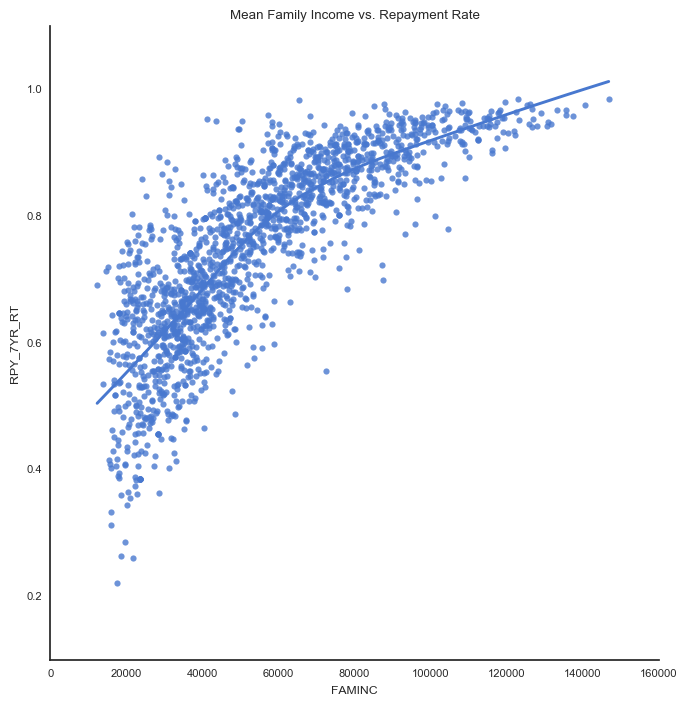

In [408]:
#Examine the relationship between Family income and repayment rate.
sns.lmplot("FAMINC","RPY_7YR_RT",data=df08, size=7, fit_reg=True, lowess=True)
plt.title(r'Mean Family Income vs. Repayment Rate')

###### Coefficients Using Lasso

In [374]:
# Fit a Logistic Regression Model. No tuning of hyper-parameters just yet.
lr = Lasso()
lr.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [100]:
mse = mean_squared_error(y_test, lr.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 0.0051


In [101]:
y_true = y_test
y_pred = lr.predict(X_test)

rfr_r2 = r2_score(y_true, y_pred)
rfr_r2

0.72037145952811033

In [106]:
# 
coefficients = pd.DataFrame(lr.coef_,
                                   index = features,
                                    columns=['coefficients'])
coefficients.sort_values(by='coefficients', ascending=False)

,coefficients
MD_INC_DEBT_N,5.578702e-05
AVGFACSAL,1.157682e-05
CUML_DEBT_P10,1.129169e-05
PAR_ED_N,9.134549e-06
CUML_DEBT_P75,7.978290e-06
HI_INC_DEBT_MDN,4.170252e-06
FIRSTGEN_DEBT_MDN,2.746073e-06
INEXPFTE,2.623190e-06
MD_FAMINC,2.046876e-06
FAMINC_IND,1.274934e-06


## Modelling & Technical Analysis
---

**Feature Set:** From the feature importance above it's clear we have a single dominating feature - Family Income. There are 27 features below which will be included in the final model based on their level of feature importance. We cut the list off when the features started to become meaningless. e.g. number of undergrads.

---
### Models:

The model will be built on the Extra Trees regression model for the Sklearn library. It has a lot of the benefits of Decisions Trees mentioned above with the added benefit of making the splits completely randomly, as a result any errors in the model makes are uncorrelated.

###### Extra Trees

In [109]:
# Set a dataframe for our model.
df08m3 = df08[[
"FAMINC",
"INC_PCT_M1",
"PELL_EVER",
"PCTPELL",
"INC_PCT_LO",
"ENRL_ORIG_YR2_RT",
"MD_FAMINC",
"DEP_INC_AVG",
"PAR_ED_PCT_PS",
"WDRAW_ORIG_YR2_RT",
"AVGFACSAL",
"PAR_ED_PCT_HS",
"INEXPFTE",
"DEP_INC_PCT_LO",
"LO_INC_DEBT_N",
"CUML_DEBT_P90",
"PAR_ED_PCT_1STGEN",
"LOAN_EVER",
"PFTFTUG1_EF",
"ENRL_4YR_TRANS_YR2_RT",
"INC_PCT_H2",
"UNKN_ORIG_YR2_RT",
"REGION",
"FIRST_GEN",
"CUML_DEBT_P25",
"FAMINC_IND",
"IND_INC_AVG",]]

In [205]:
#Define the X and y.
features = [c for c in df08m3.columns]

X3 = df08m3[features]
y3 = df08rf['RPY_7YR_RT']

In [210]:
# Generate a train, test split.
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.3)

In [195]:
# Grid Search the best hypere parameters.
etr = ExtraTreesRegressor() 

param_grid3 = { 
    'n_estimators': [5,50,100,200,300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': ['True','False']
}

CV_etr = GridSearchCV(estimator=etr, param_grid=param_grid3, cv= 5)
CV_etr.fit(X_train3, y_train3)
print CV_etr.best_params_

{'max_features': 'auto', 'n_estimators': 200, 'bootstrap': 'True'}


In [207]:
# Refit the model with optimized hyper parameters.
etr_best = RandomForestRegressor(n_estimators=200, max_features='auto', bootstrap=True)
etr_best.fit(X_train3, y_train3)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [211]:
# Examine the model error to ensure our model has value.
mse = mean_squared_error(y_test3, etr_best.predict(X_test3))
print("MSE: %.4f" % mse)

MSE: 0.0015


In [212]:
# Review the R2 value to see if the model has predictive power.
y_true = y_test3
y_pred = etr_best.predict(X_test3)

rfr_r2 = r2_score(y_true, y_pred)
print("R2 Score: %.4f" % rfr_r2)

R2 Score: 0.9249


### Interpretation
---
The mean squared error of our model is a mere 0.0015. In other words, the average distance squared between where our model predicted a data point would be and where it actually existed was only, 0.0015. We could possibly do some further fine tunning but this is an extremely high result already. Further, the r2 or how much of the variance in the data can be explained in our model is approximately 92%. Also, a very strong result.

In [ ]:
#Blank

### Modeling Repayment Rate Across Family Income

In [161]:
pd.set_option('display.max_columns', None)
df08m3.describe()

,FAMINC,INC_PCT_M1,PELL_EVER,PCTPELL,INC_PCT_LO,ENRL_ORIG_YR2_RT,MD_FAMINC,DEP_INC_AVG,PAR_ED_PCT_PS,WDRAW_ORIG_YR2_RT,AVGFACSAL,PAR_ED_PCT_HS,INEXPFTE,DEP_INC_PCT_LO,LO_INC_DEBT_N,CUML_DEBT_P90,PAR_ED_PCT_1STGEN,LOAN_EVER,PFTFTUG1_EF,ENRL_4YR_TRANS_YR2_RT,INC_PCT_H2,UNKN_ORIG_YR2_RT,REGION,FIRST_GEN,CUML_DEBT_P25,FAMINC_IND,IND_INC_AVG
count,1703.000000,1703.000000,1703.000000,1703.000000,1703.000000,1703.000000,1703.000000,1703.000000,1703.000000,1703.000000,1703.000000,1703.000000,1703.000000,1703.000000,1703.000000,1703.000000,1703.000000,1703.000000,1703.000000,1703.000000,1703.000000,1703.000000,1703.000000,1703.000000,1703.000000,1703.000000,1703.000000
mean,54345.065520,0.156155,0.665031,0.309264,0.489084,0.330162,42434.689461,65084.863234,0.585140,0.210408,6331.170288,0.401534,6830.530534,0.393724,1335.477980,20029.196418,0.415213,0.784912,0.562327,0.080572,0.099133,0.127713,4.194363,0.415213,3862.004991,26370.498195,26370.498195
std,25861.931913,0.030324,0.182355,0.180240,0.193648,0.158509,23073.269901,25783.463099,0.120212,0.105177,1792.005664,0.083893,6131.178567,0.169401,5567.806675,7280.367826,0.120495,0.248785,0.232041,0.033655,0.090818,0.120796,2.151799,0.120495,1600.595357,10058.579226,10058.579226
min,12305.261610,0.053159,0.088435,0.008100,0.093923,0.009443,7565.174957,16472.370991,0.284029,0.017417,978.000000,0.098077,0.000000,0.078416,11.000000,4000.000000,0.070332,0.025584,0.000000,0.004976,0.001726,0.007407,1.000000,0.070332,1000.000000,2953.007758,2953.007758
25%,33721.401405,0.136999,0.522691,0.183050,0.325391,0.210016,23998.394230,45194.883784,0.496492,0.130897,5061.500000,0.360890,3998.000000,0.247482,215.500000,14445.500000,0.337497,0.694085,0.389750,0.061028,0.031395,0.049084,2.000000,0.337497,2625.000000,19601.715080,19601.715080
50%,49574.881010,0.157683,0.669304,0.274700,0.485564,0.315324,35960.872830,62410.039881,0.568983,0.196281,6122.000000,0.432206,5514.000000,0.396610,469.000000,20875.000000,0.431017,0.915172,0.589900,0.073069,0.060734,0.069444,4.000000,0.431017,3500.000000,24349.593591,24349.593591
75%,71378.105285,0.175100,0.815937,0.387600,0.645356,0.447214,57155.579590,83168.171447,0.662503,0.270959,7348.000000,0.446950,7589.000000,0.500550,1186.500000,24625.000000,0.504329,0.951637,0.736900,0.097298,0.142372,0.170998,5.000000,0.504329,4875.000000,31199.764050,31199.764050
max,146837.736900,0.364583,0.995036,0.993400,0.900770,0.806957,121531.383900,151819.534950,0.929668,0.673139,15403.000000,0.680992,89335.000000,0.855799,187855.000000,46000.000000,0.715971,0.992810,1.000000,0.300654,0.477311,0.709115,8.000000,0.715971,13621.500000,86808.463783,86808.463783


In [163]:
df08m3[features].columns

Index([u'FAMINC', u'INC_PCT_M1', u'PELL_EVER', u'PCTPELL', u'INC_PCT_LO',
       u'ENRL_ORIG_YR2_RT', u'MD_FAMINC', u'DEP_INC_AVG', u'PAR_ED_PCT_PS',
       u'WDRAW_ORIG_YR2_RT', u'AVGFACSAL', u'PAR_ED_PCT_HS', u'INEXPFTE',
       u'DEP_INC_PCT_LO', u'LO_INC_DEBT_N', u'CUML_DEBT_P90',
       u'PAR_ED_PCT_1STGEN', u'LOAN_EVER', u'PFTFTUG1_EF',
       u'ENRL_4YR_TRANS_YR2_RT', u'INC_PCT_H2', u'UNKN_ORIG_YR2_RT', u'REGION',
       u'FIRST_GEN', u'CUML_DEBT_P25', u'FAMINC_IND', u'IND_INC_AVG'],
      dtype='object')

In [ ]:
u'FAMINC', u'INC_PCT_M1', u'PELL_EVER', u'PCTPELL', u'INC_PCT_LO',
       u'ENRL_ORIG_YR2_RT', u'MD_FAMINC', u'DEP_INC_AVG', u'PAR_ED_PCT_PS',
       u'WDRAW_ORIG_YR2_RT', u'AVGFACSAL', u'PAR_ED_PCT_HS', u'INEXPFTE',
       u'DEP_INC_PCT_LO', u'LO_INC_DEBT_N', u'CUML_DEBT_P90',
       u'PAR_ED_PCT_1STGEN', u'LOAN_EVER', u'PFTFTUG1_EF',
       u'ENRL_4YR_TRANS_YR2_RT', u'INC_PCT_H2', u'UNKN_ORIG_YR2_RT', u'REGION',
       u'FIRST_GEN', u'CUML_DEBT_P25', u'FAMINC_IND', u'IND_INC_AVG'

In [268]:
# Initialize the values we need. Family income is initialized near the min.
fi = 10000
y = 0
targets = []
fam_inc = []

# Incriment the family income and repredict the target. Family income terminates near the max.
for i in range(35):
    fi += 4000
    x_fet = [fi, 0.156155, 0.665031, 0.309264, 0.489084, 0.330162, 42434.689461, 65084.863234, 0.585140, 0.210408, 6331.170288, 0.401534, 6830.530534, 0.393724, 1335.477980, 20029.196418, 0.415213, 0.784912, 0.562327, 0.080572, 0.099133, 0.127713, 4.194363, 0.415213, 3862.004991, 26370.498195, 26370.498195]
    y = etr_best.predict(x_fet)
    targets.append(y)
    fam_inc.append(fi)
    

# Build a dataframe from our list of values.
df = pd.DataFrame()
df['FAMILYINC'] = fam_inc
df['RPY_RATE'] = targets
df.head()

,FAMILYINC,RPY_RATE
0,14000,[0.738005081215]
1,18000,[0.738005081215]
2,22000,[0.738005081215]
3,26000,[0.738005081215]
4,30000,[0.738005081215]


In [269]:
df["RPY_R"] = np.array(df["RPY_RATE"], dtype=float)

In [270]:
del df["RPY_RATE"]

In [271]:
df.head()

,FAMILYINC,RPY_R
0,14000,0.738005
1,18000,0.738005
2,22000,0.738005
3,26000,0.738005
4,30000,0.738005


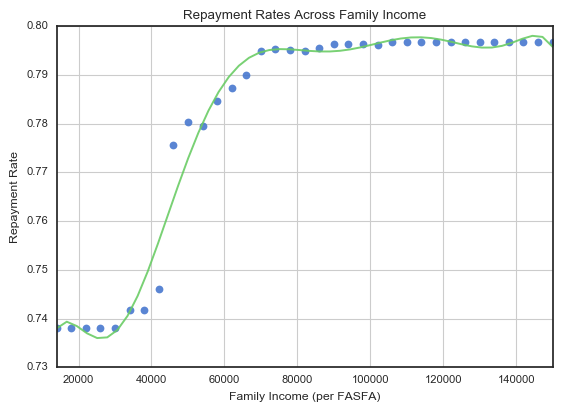

In [354]:
x = np.array(df["FAMILYINC"])
y = np.array(df["RPY_R"])

# calculate polynomial
z = np.polyfit(x, y, 8)
f = np.poly1d(z)

# calculate new x's and y's
x_new = np.linspace(x[0], x[-1], 50)
y_new = f(x_new)

plt.style.use('seaborn-muted')
plt.plot(x,y,'o', x_new, y_new, alpha=.9)
plt.xlim([x[0]-1, x[-1] + 1 ])
plt.xlabel("Family Income (per FASFA)")
plt.ylabel('Repayment Rate')
plt.title('Repayment Rates Across Family Income')
plt.grid(True)
plt.show()

## Conclusion & Recommendations
---
The final figure looks a how repayment rates change for the an average university as the mean income increases. There is a lot of explanitory value in the chart. We can see that students who have family incomes less than about \$35K are caught by the safety nets inplace and so below \$35K family income doesn't matter a whole lot. The same is true for students who have family incomes above \$70K, they often have no trouble paying for college and family income is not all that important. However, for students with family incomes in the middle range, their family income is massively important. Extrapolating out from the institution level, the difference in repayment rate between a student who comes from a family that makes \$35K and on that makes \$70k is almost 6%\!

As a university administor I would use this data to focus resources on these students. The good news here too is that this data was pulled from the FASFA filings, which means the university has access to this information for each student and they have early in the students college career. 

For student loan originators, (and potential student loan originators) this analysis comes at a critical time in the market. A recent [Bloomberg article](https://www.bloomberg.com/news/articles/2016-12-12/obama-administration-deals-another-blow-to-student-loan-giant-navient) points out that Navient (formerly Sallie Mae) has lost the contract to collect on defaulted federal student loans and could be at risk for lossing other federal business as well. This leaves an opportunity for new entry into the market by a player who better understands the forces driving risk and defaults in the student loan business. 